In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline



env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

W0919 21:33:47.250261 139634858186560 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W0919 21:33:47.324943 139634858186560 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [3]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
mumbai = data_dir/"AOI_8_Mumbai"
ms_mumbai = mumbai/"MS"
ps_rgb_mumbai = mumbai/"PS-RGB"
mask_folder = mumbai / "masks"

In [4]:
from utils import create_small_tiles, scale_percentile

In [4]:
mask_folder = mumbai / "masks"

mask_512_folder = mumbai /"masks_512"
mask_512_folder.mkdir(exist_ok=True)

rgb_512_folder = mumbai /"rgb_512"
rgb_512_folder.mkdir(exist_ok=True)

img_fnames = ps_rgb_mumbai.ls()
img_ids = [x.name.replace('.tif', '').split('_')[-1] for x in img_fnames]
mask_fnames =[ mask_folder / f"{img_id}.png" for img_id in img_ids]



In [5]:
valid_imgs = list(set([x.name.split('_')[2] for x in rgb_512_folder.ls() if x.name.endswith('.jpg')]))
np.random.seed(42)
mumbai_ids = np.array(valid_imgs)
np.random.shuffle(mumbai_ids)
np.random.seed(None)

In [6]:
len(valid_imgs), len(mumbai_ids)

(641, 641)

#### modelling setup

using a previously saved set of train/validation splits

In [8]:
train_val_ids_df = pd.read_csv(data_dir /"train_val_split_ids.csv")
train_ids= train_val_ids_df[train_val_ids_df.is_train ==True]['id']
val_ids= train_val_ids_df[train_val_ids_df.is_train ==False]['id']

In [9]:
def get_mask_fn(fname):
    return mask_512_folder / fname.name.replace("rgb", "mask").replace("jpg", "png")


def is_valid_image(filepath):
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in mumbai_ids

def is_in_validation_set(filepath):
    img_name = Path(filepath).name
    img_id = img_name.split('_')[2]
    return img_id in valid_ids

codes = np.array(["void", "road"])

src = (SegmentationItemList.from_folder(rgb_512_folder)
       .filter_by_func(is_valid_image)
       .split_by_valid_func(is_in_validation_set)
       .label_from_func(get_mask_fn, classes=codes)
      )

bs = 4
size=256

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

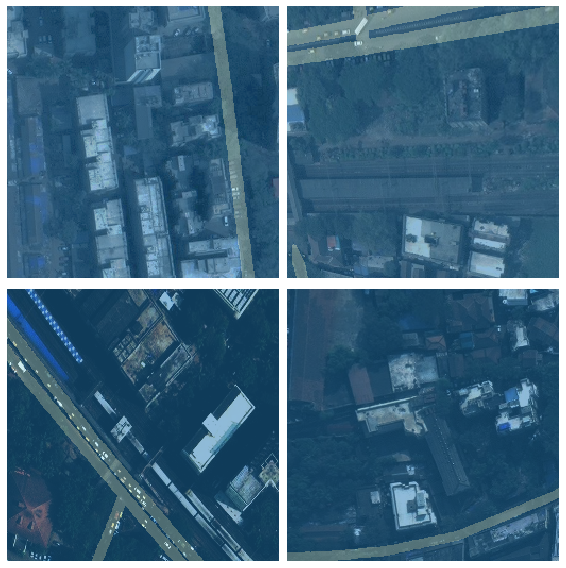

In [10]:
data.show_batch()

In [12]:
from ptsemseg.models import linknet, get_model

In [15]:
linknet(n_classes=2, )

In [10]:
wd =1e-2
metrics = [partial(foreground_acc, void_code=0),dice]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (15926 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Valid: LabelList (3960 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentu

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


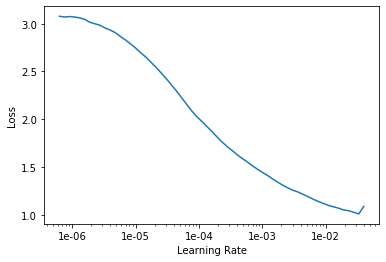

In [13]:
learn.recorder.plot(skip_end=1)

In [15]:
lr=1e-3
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-resnet34-1')]
learn.fit_one_cycle(20, slice(lr), callbacks=callbacks)

Better model found at epoch 0 with dice value: 0.5050227046012878.
Better model found at epoch 1 with dice value: 0.5176989436149597.
Better model found at epoch 2 with dice value: 0.5208874344825745.


KeyboardInterrupt: 

In [24]:
learn.load('mumbai-model-resnet34-1')

Learner(data=ImageDataBunch;

Train: LabelList (15926 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Valid: LabelList (3960 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentu

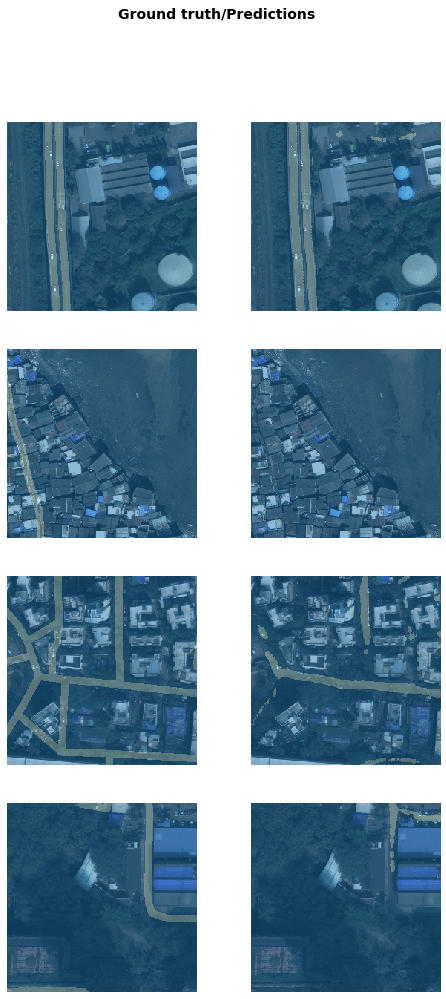

In [17]:
learn.show_results()

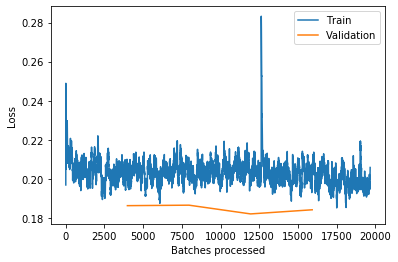

In [20]:
# learn.lr_find()
learn.recorder.plot_losses(skip_end=5000)

Min numerical gradient: 3.02E-03
Min loss divided by 10: 2.75E-03


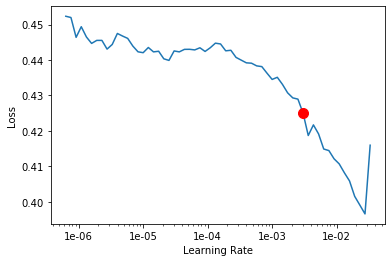

In [22]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Hmm, the training loss exploded... maybe learning rate too high? Anyway, let's try again with some better callbacks

In [25]:
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-resnet34-2'),
          TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

lr=4e-3
learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)

Better model found at epoch 0 with dice value: 0.0.
Epoch 1: reducing lr to 0.0007603709340887606


KeyboardInterrupt: 

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.to_fp16()

file='mumbai-model-resnet34-1'
source = rgb_512_folder/"models"/f'{file}.pth' 
state = torch.load(source, map_location=data.device)


In [33]:
model_state = state['model']
get_model(learn.model).load_state_dict(model_state, strict=True)


<All keys matched successfully>

In [34]:
del state
gc.collect()

26336

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


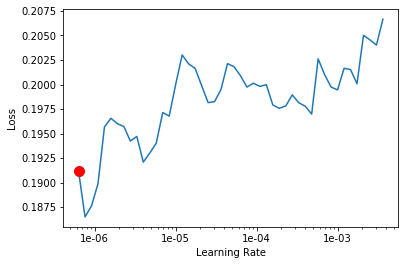

In [35]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [38]:
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='mumbai-model-resnet34-2'),
          TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

lr=1e-6
learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)

Better model found at epoch 0 with dice value: 0.5318765044212341.
Better model found at epoch 1 with dice value: 0.5416579842567444.
Better model found at epoch 2 with dice value: 0.544073760509491.


#### predictions

Let's look at how the model does on the validation set:

In [ ]:
learn.load("mumbai-model-resnet34-2")

In [40]:
predictions = learn.get_preds(DatasetType.Valid)

In [43]:
predictions[0][0].shape

torch.Size([2, 256, 256])

In [ ]:
prediction_masks_512= nn.UpsamplingNearest2d(scale_factor=2)(predictions[0])

In [41]:
learn.data.valid_dl.x.items

array([PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip313_680_510.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip62_340_0.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip307_170_680.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip180_340_170.jpg'), ...,
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip668_680_0.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip195_510_788.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip805_340_510.jpg'),
       PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/rgb_512/rgb_512_chip244_510_510.jpg')],
      dtype=object)

In [52]:
to_combine = []
mask_width = predictions[0][0].shape[1]
full_img_width = 1300//2 # this is becuase we resized the mask to be 1/2
for mask, fpath in zip(predictions[0],learn.data.valid_dl.x.items):
    full_img = np.zeros((full_img_width,full_img_width))

    start_index_row, start_index_col = [int(x)//2 for x in fpath.name.replace('.jpg','').split('_')[3:]]

    full_img[start_index_row:start_index_row+mask_width, start_index_col: start_index_col+mask_width] = torch.argmax(mask,0).numpy()
    to_combine.append(full_img)


In [97]:
def process_one_img(img_id, predictions, filepaths_list):
    to_combine = []
    valid_idx_mask = [x.name.split('_')[2] == img_id for x in filepaths_list]
#     valid_idx_mask = [x.name.split('_')[2] == img_id for x in learn.data.valid_dl.x.items]
    fpaths = filepaths_list[list(np.argwhere(valid_idx_mask).ravel())]
#     fpaths = learn.data.valid_dl.x.items[list(np.argwhere(valid_idx_mask).ravel())]
    for mask, fpath in zip(predictions[0][valid_idx_mask], fpaths):
        full_img = np.zeros((full_img_width,full_img_width))

        start_index_row, start_index_col = [int(x)//2 for x in fpath.name.replace('.jpg','').split('_')[3:]]


        full_img[start_index_row:start_index_row+mask_width, start_index_col: start_index_col+mask_width] = torch.argmax(mask,0).numpy()
        to_combine.append(full_img)
    out = np.sum(np.array(to_combine), axis=0)
    out=np.clip(out, 0,1)
    return out


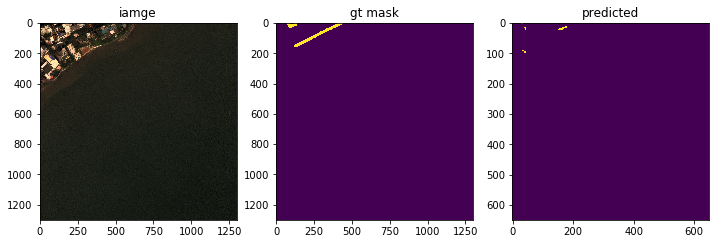

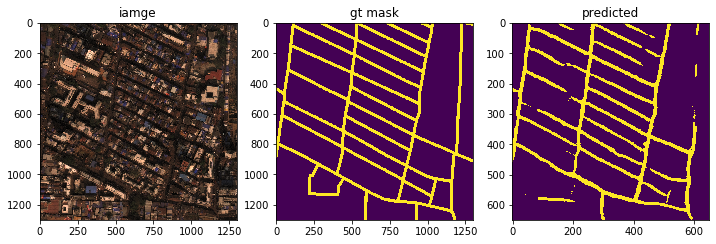

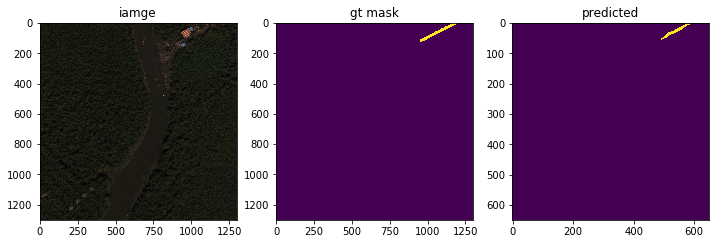

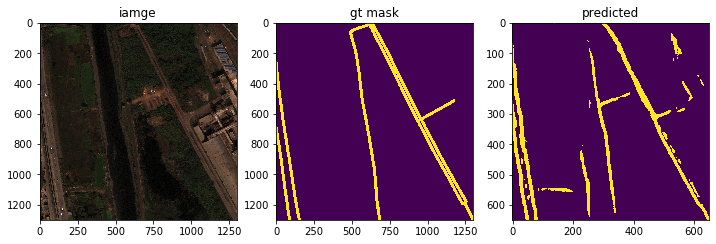

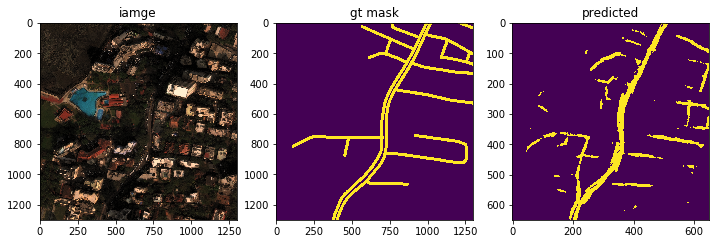

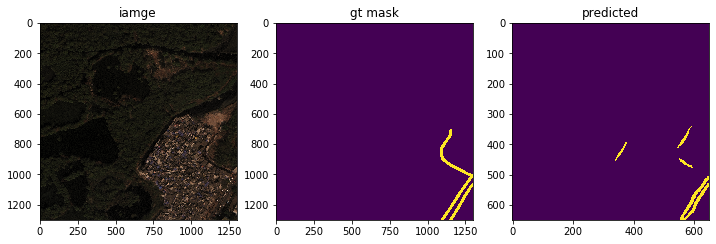

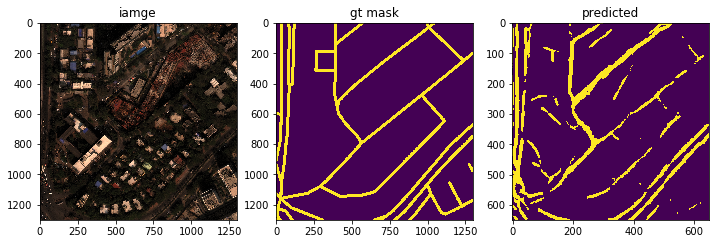

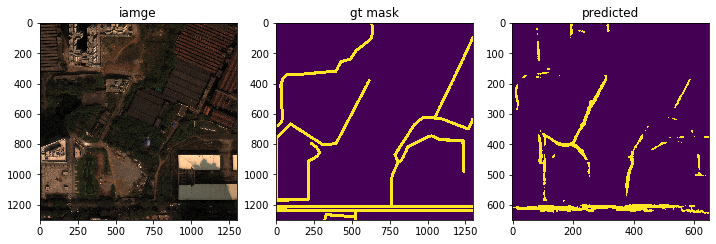

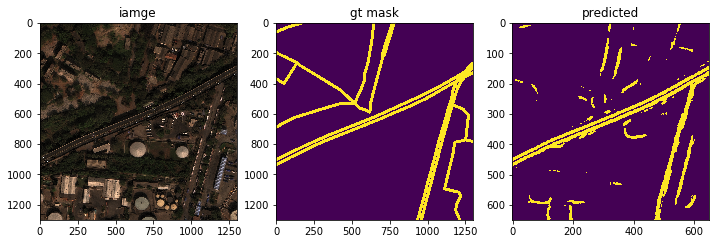

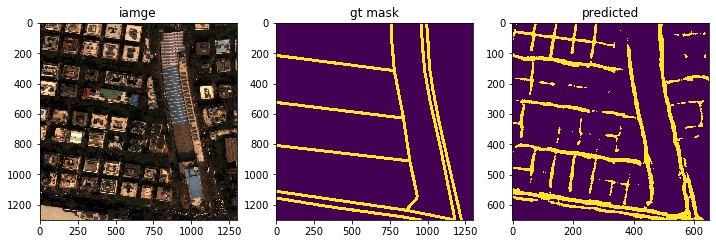

In [99]:
for img_id in valid_ids[:10]:
    predicted= process_one_img(img_id,predictions, learn.data.valid_dl.x.items)
    image = sktif.imread(str(ps_rgb_mumbai / f"SN5_roads_train_AOI_8_Mumbai_PS-RGB_{img_id}.tif"))
    mask = PIL.Image.open(mask_folder/f"{img_id}.png")
    fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(12,8))
    ax = axes.ravel()

    ax[0].imshow(image);
    ax[0].set_title('iamge');
    ax[1].imshow(mask);
    ax[1].set_title('gt mask');
    ax[2].imshow(predicted);
    ax[2].set_title('predicted');

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


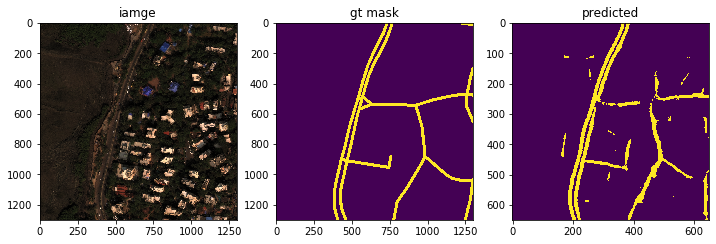

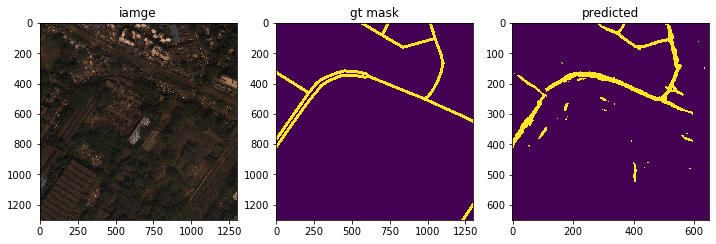

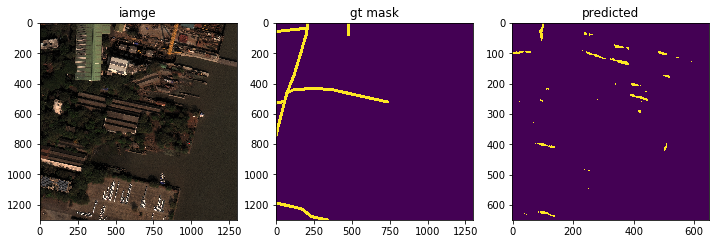

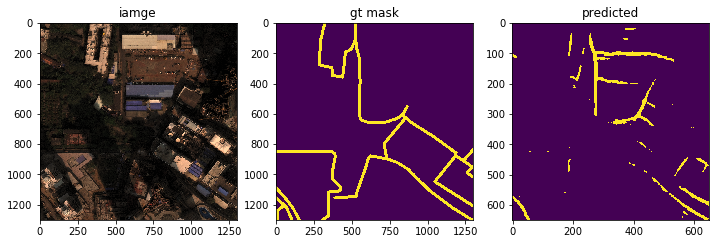

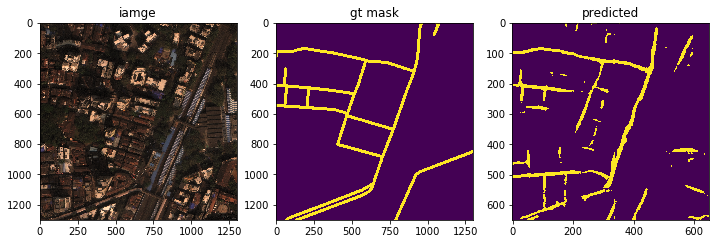

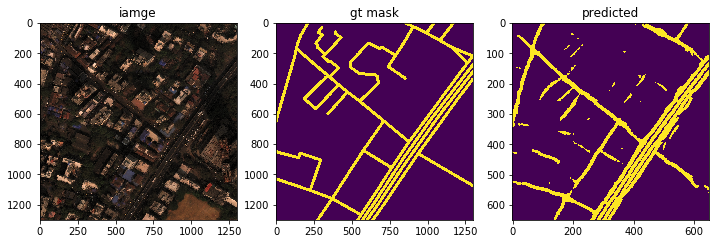

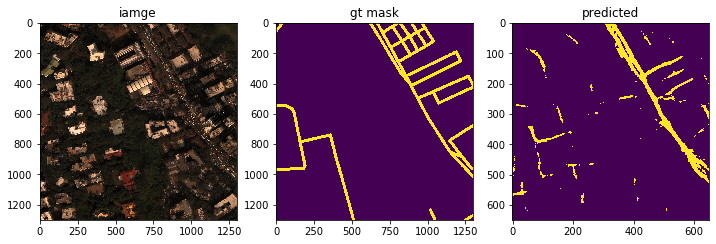

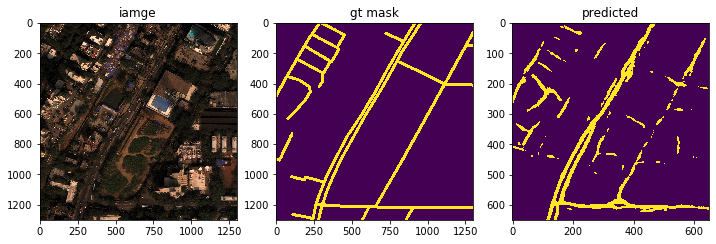

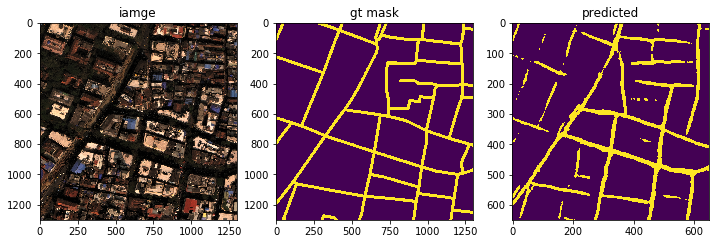

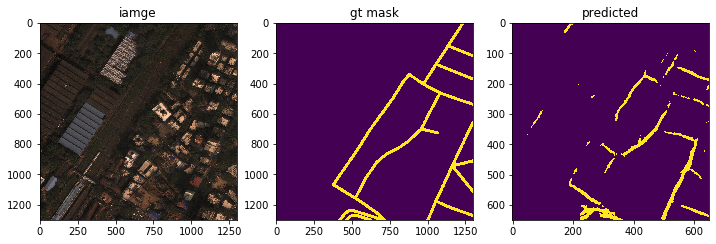

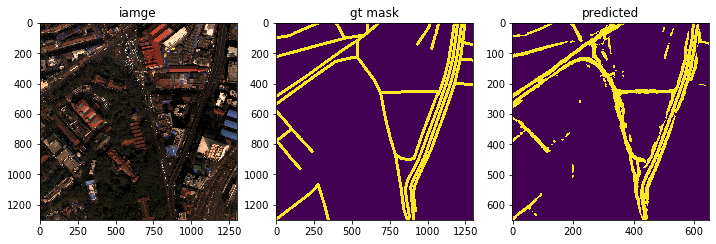

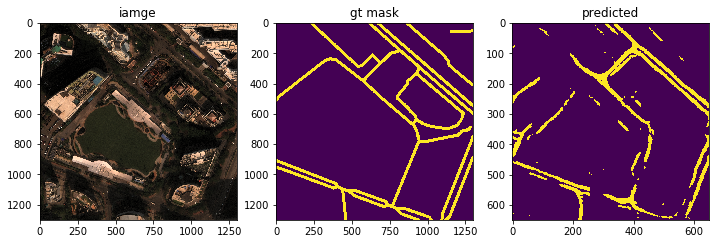

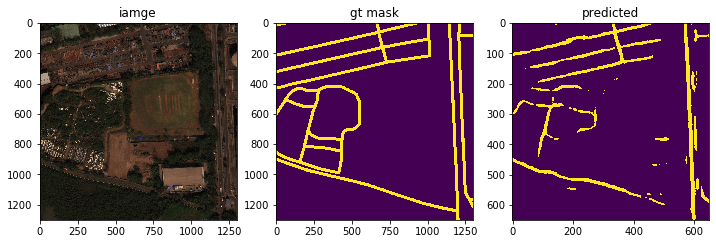

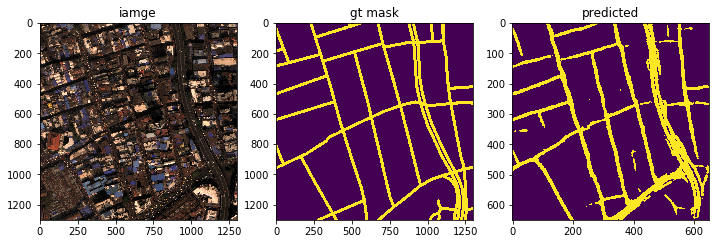

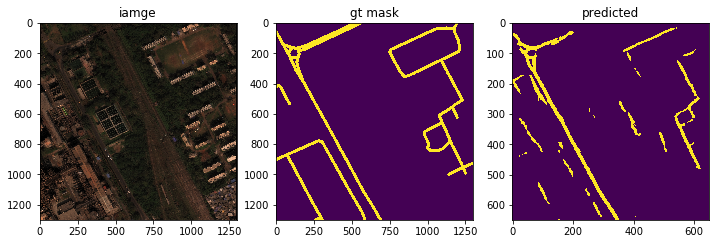

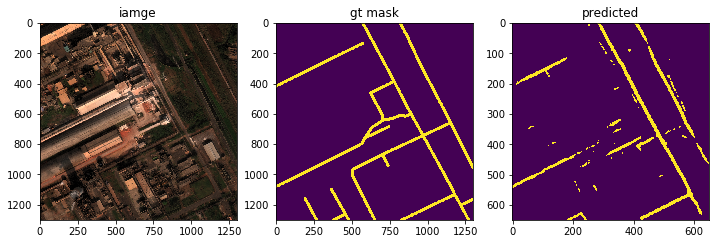

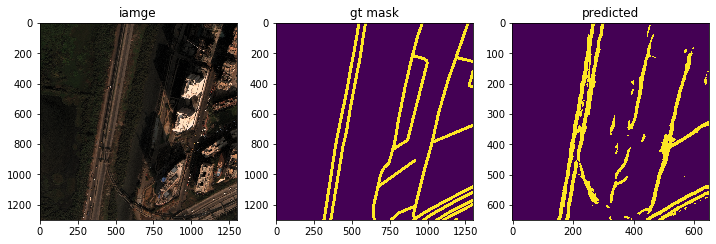

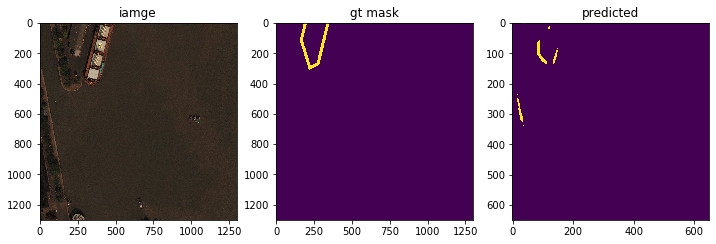

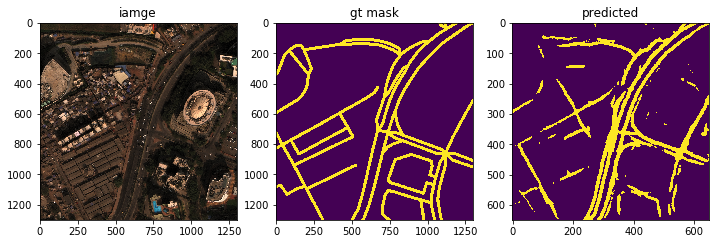

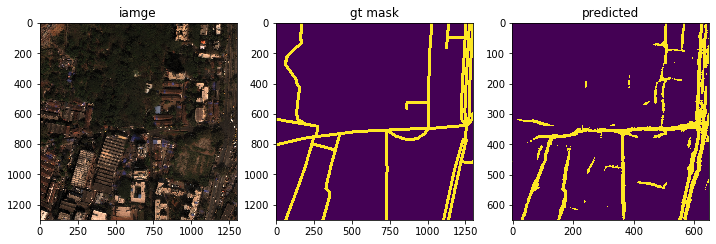

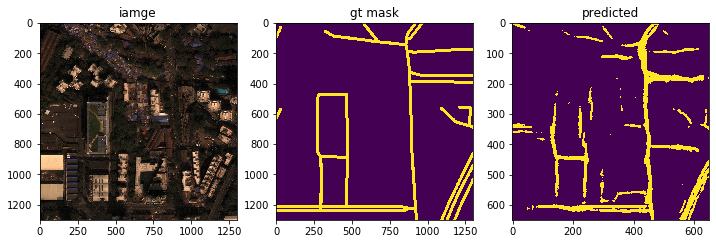

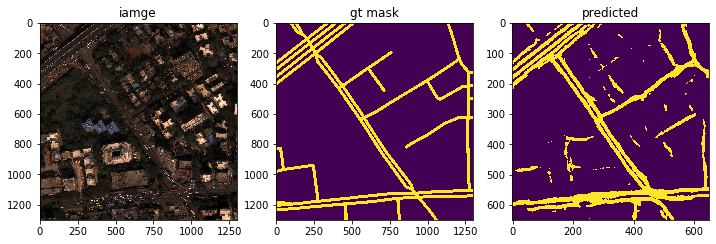

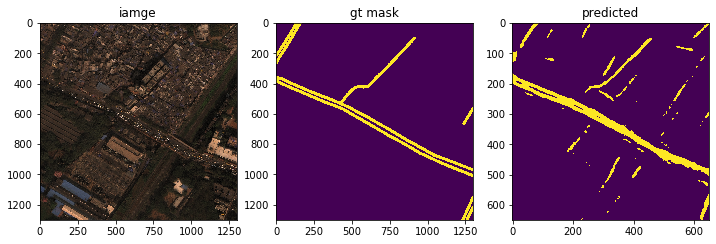

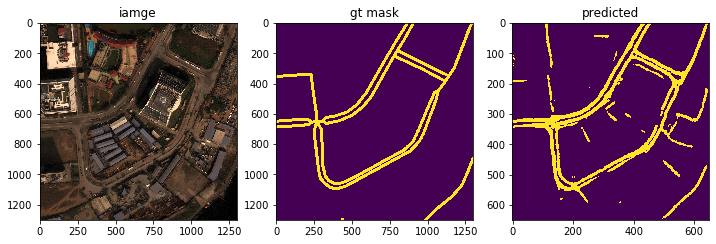

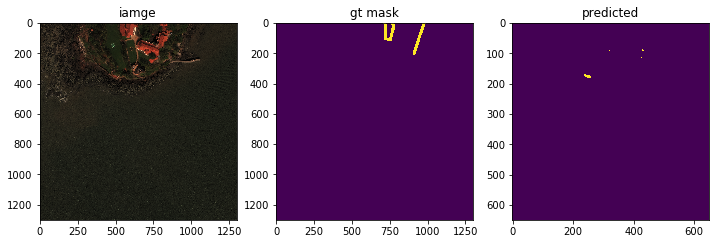

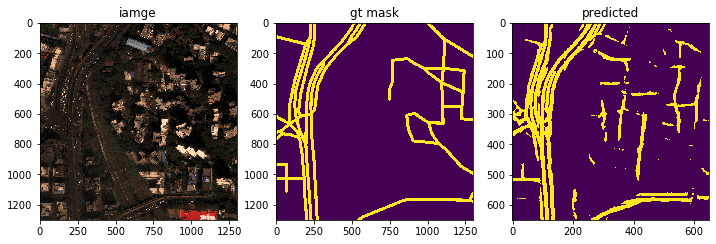

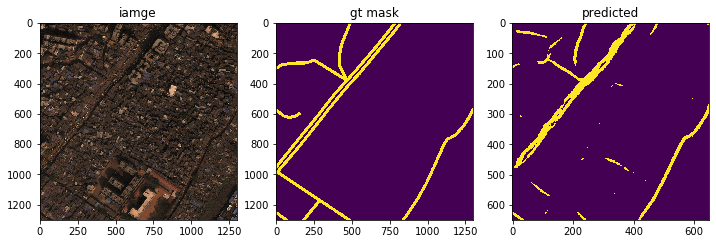

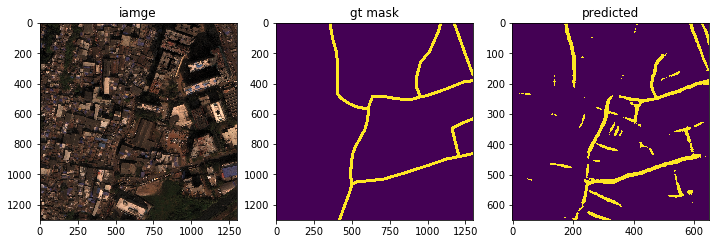

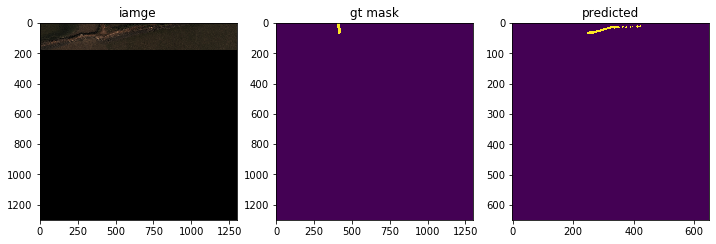

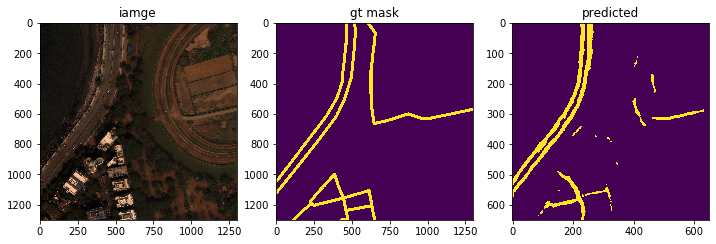

In [102]:
for img_id in valid_ids[10:40]:
    predicted= process_one_img(img_id,predictions, learn.data.valid_dl.x.items)
    image = sktif.imread(str(ps_rgb_mumbai / f"SN5_roads_train_AOI_8_Mumbai_PS-RGB_{img_id}.tif"))
    mask = PIL.Image.open(mask_folder/f"{img_id}.png")
    fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(12,8))
    ax = axes.ravel()

    ax[0].imshow(image);
    ax[0].set_title('iamge');
    ax[1].imshow(mask);
    ax[1].set_title('gt mask');
    ax[2].imshow(predicted);
    ax[2].set_title('predicted');
    
    fig.close()

not bad, getting there...

In [105]:
# one final sanity check that we're not training and predicting on the same images...
a = set([x.name.split('_')[2] for x in learn.data.valid_dl.x.items])
b = set([x.name.split('_')[2] for x in learn.data.train_dl.x.items])

a.intersection(b)

set()